# Deep Averaging Networks for text classification

- pytorch, spacy, deep averaging networks
- GloVe word embeddings, frozen and fine-tuned weights
- S&P Key Developments

Terence Lim


In [1]:
# jupyter-notebook --NotebookApp.iopub_data_rate_limit=1.0e12
import numpy as np
import os
import time
import re
import csv, gzip, json
import pandas as pd
from pandas import DataFrame, Series
import matplotlib.pyplot as plt
from tqdm import tqdm
from collections import Counter
from nltk.tokenize import RegexpTokenizer
import torch
import torch.nn as nn
import random
from finds.database import MongoDB
from finds.unstructured import Unstructured
from finds.structured import PSTAT
from finds.learning import TextualData
from settings import settings
from settings import pickle_dump, pickle_load
mongodb = MongoDB(**settings['mongodb'])
keydev = Unstructured(mongodb, 'KeyDev')
imgdir = os.path.join(settings['images'], 'classify')
memdir = settings['memmap']
event_ = PSTAT.event_
role_ = PSTAT.role_
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Retrieve headline+situation text
events = [28, 16, 83, 41, 81, 23, 87, 45, 80, 97,  231, 46, 31, 77, 29,
          232, 101, 42, 47, 86, 93, 3, 22, 102, 82]

In [2]:
if False:
    lines = []
    event_all = []
    tokenizer = RegexpTokenizer(r"\b[^\d\W][^\d\W][^\d\W]+\b")
    for event in events:
        docs = keydev['events'].find({'keydeveventtypeid':{'$eq':event}}, {'_id':0})
        doc = [tokenizer.tokenize((d['headline'] + " " + d['situation']).lower())
               for d in docs]
        lines.extend(doc)
        event_all.extend([event] * len(doc))
    with gzip.open(os.path.join(imgdir, 'lines.json.gz'), 'wt') as f:
        json.dump(lines, f)
    with gzip.open(os.path.join(imgdir,'event_all.json.gz'), 'wt') as f:
        json.dump(event_all, f)
    print(lines[1000000])

['advanced', 'enzyme', 'technologies', 'limited', 'proposes', 'final', 'dividend', 'for', 'the', 'financial', 'year', 'advanced', 'enzyme', 'technologies', 'limited', 'board', 'directors', 'their', 'meeting', 'held', 'may', 'have', 'proposed', 'the', 'final', 'dividend', 'for', 'the', 'financial', 'year', 'inr', 'per', 'equity', 'share', 'and', 'same', 'will', 'accrued', 'and', 'paid', 'after', 'approval', 'shareholders', 'the', 'annual', 'general', 'meeting', 'the', 'company']


In [2]:
if False:
    with gzip.open(os.path.join(imgdir, 'lines.json.gz'), 'rt') as f:
        lines = json.load(f)
with gzip.open(os.path.join(imgdir,'event_all.json.gz'), 'rt') as f:
    event_all = json.load(f)

## Collect all text into data, and encode labels


In [3]:
## Encode class labels
from sklearn.preprocessing import LabelEncoder
event_encoder = LabelEncoder().fit(event_all)    # .inverse_transform()
num_classes = len(np.unique(event_all))
y_all = event_encoder.transform(event_all)

Series(event_all).value_counts().rename(index=event_).rename('count').to_frame()

,count
Announcements of Earnings,244140
Executive/Board Changes - Other,128019
Private Placements,113007
Product-Related Announcements,93172
M&A Transaction Closings,90955
Client Announcements,90687
Fixed Income Offerings,69652
Dividend Affirmations,53704
M&A Transaction Announcements,43305
Special/Extraordinary Shareholders Meeting,32572


## split into train and test indices
- stratify by event label frequencies

In [4]:
from sklearn.model_selection import train_test_split
train_idx, test_idx = train_test_split(np.arange(len(y_all)), random_state=42,
                                       stratify=y_all, test_size=0.2)

## Load spacy and vocab


In [5]:
import spacy
lang = 'en_core_web_lg'
nlp = spacy.load(lang, disable=['parser', 'tagger', 'ner', 'lemmatizer'])
for w in ['yen', 'jpy', 'eur', 'dkk', 'cny', 'sfr']:
    nlp.vocab[w].is_stop = True    # Mark customized stop words
    
n_vocab, vocab_dim = nlp.vocab.vectors.shape
print('Language:', lang, '   vocab:', n_vocab, '   dim:', vocab_dim)


Language: en_core_web_lg    vocab: 684830    dim: 300


## Precompute word embeddings input

In [9]:
def form_input(line, nlp):
    """Return spacy average vector from valid words"""
    tokens = [tok.vector for tok in nlp(" ".join(line))
              if not(tok.is_stop or tok.is_punct or tok.is_oov or tok.is_space)]
    return (np.array(tokens).mean(axis=0) if len(tokens) else
            np.zeros(nlp.vocab.vectors.shape[1]))

args = {'dtype': 'float32'}
memdir = '/home/terence/Downloads/stocks2020/memmap/'
if False:
    args.update({'mode': 'r+', 'shape': (len(lines), vocab_dim)})
    X = np.memmap(os.path.join(memdir, "X.{}_{}".format(*args['shape'])),**args)
    for i, line in tqdm(enumerate(lines)):
        X[i] = form_input(line, nlp).astype(args['dtype'])
args.update({'shape': (1224251, vocab_dim), 'mode': 'r'})
X = np.memmap(os.path.join(memdir, "X.{}_{}".format(*args['shape'])), **args)

## Feed Forward Network in Pytorch
- FFNN with averaged bag of word embeddings

In [10]:
class FFNN(nn.Module):
    """Deep Averaging Network for classification"""
    def __init__(self, vocab_dim, num_classes, hidden, dropout=0.3):
        super().__init__()
        V = nn.Linear(vocab_dim, hidden[0])
        nn.init.xavier_uniform_(V.weight)
        L = [V, nn.Dropout(dropout)]
        for g, h in zip(hidden, hidden[1:] + [num_classes]):
            W = nn.Linear(g, h)
            nn.init.xavier_uniform_(W.weight)
            L.extend([nn.ReLU(), W])
        self.network = nn.Sequential(*L)
        self.classifier = nn.LogSoftmax(dim=-1)  # output is (N, C) logits

    def forward(self, x):
        """Return tensor of log probabilities"""
        return self.classifier(self.network(x))

    def predict(self, x):
        """Return predicted int class of input tensor vector"""
        return torch.argmax(self(x), dim=1).int().tolist()
            
    def save(self, filename):
        """save model state to filename"""
        return torch.save(self.state_dict(), filename)

    def load(self, filename):
        """load model name from filename"""
        self.load_state_dict(torch.load(filename, map_location='cpu'))
        return self

## Training Loops
- Instantiate model, optimizer, scheduler, loss_function for range of layers selection
- Loops over epochs and batches

In [11]:
accuracy = {}  # to store computed metrics
max_layers, hidden = 2, 300 #3, 300
batch_sz, lr, num_lr, step_sz, eval_skip = 64, 0.01, 4, 10, 5 #3, 3, 3 
num_epochs = step_sz * num_lr + 1
for layers in [max_layers]:

    # Instantiate model, optimizer, scheduler, loss_function
    model = FFNN(vocab_dim=vocab_dim, num_classes=num_classes,
                 hidden=[hidden]*layers).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, gamma=0.1,
                                                step_size=step_sz)
    loss_function = nn.NLLLoss()
    accuracy[layers] = {}

    # Loop over epochs and batches
    for epoch in range(0, num_epochs):
        tic = time.time()
        idxs = [i for i in train_idx]
        random.shuffle(idxs)
        batches = [idxs[i:(i+batch_sz)] for i in range(0, len(idxs), batch_sz)]
    
        total_loss = 0.0
        model.train()
        for i, batch in enumerate(batches):    # loop over minibatches
            x = torch.FloatTensor(X[batch]).to(device)
            y = torch.tensor([y_all[idx] for idx in batch]).to(device)
            model.zero_grad()                    # reset model gradient
            log_probs = model(x)                 # run model
            loss = loss_function(log_probs, y)   # compute loss
            total_loss += float(loss)
            loss.backward()      # loss step
            optimizer.step()     # optimizer step
            #print(i, batches, i/len(batches), total_loss, end='\r')
        scheduler.step()      # scheduler step
        model.eval()
        model.save(os.path.join(imgdir, f"dan{layers}.pt"))
        #print(f"Loss on epoch {epoch}: {total_loss:.1f}")

        with torch.no_grad():
            if epoch % eval_skip == 0:
                gold = np.asarray([int(y) for y in y_all])
                batches = [test_idx[i:(i+128)]
                           for i in range(0, len(test_idx), 128)]
                test_gold, test_pred = [], []
                for batch in tqdm(batches):
                    test_pred.extend(model.predict(
                        torch.FloatTensor(X[batch]).to(device)))
                    test_gold.extend(gold[batch])
                test_correct = (np.asarray(test_pred) ==
                                np.asarray(test_gold)).sum()

                batches = [train_idx[i:(i+128)]
                           for i in range(0, len(train_idx), 128)]
                train_gold, train_pred = [], []
                for batch in tqdm(batches):
                    train_pred.extend(model.predict(
                        torch.FloatTensor(X[batch]).to(device)))
                    train_gold.extend(gold[batch])
                train_correct = (np.asarray(train_pred) ==
                                 np.asarray(train_gold)).sum()
                accuracy[layers][epoch] = {
                    'loss': total_loss,
                    'train': train_correct/len(train_idx),
                    'test': test_correct/len(test_idx)}
                print(layers, epoch, int(time.time()-tic),
                      optimizer.param_groups[0]['lr'],
                      train_correct/len(train_idx), test_correct/len(test_idx))


100%|██████████| 7652/7652 [00:05<00:00, 1454.71it/s]


2 0 64 0.01 0.8825239942822136 0.881519781418087


100%|██████████| 7652/7652 [00:05<00:00, 1495.99it/s]


2 5 52 0.01 0.9000204206657137 0.8982646589150136


100%|██████████| 7652/7652 [00:05<00:00, 1489.92it/s]


2 10 52 0.001 0.9066336532570962 0.9042723942315939


100%|██████████| 7652/7652 [00:05<00:00, 1496.28it/s]


2 15 52 0.001 0.9086634674290381 0.905808022021556


100%|██████████| 7652/7652 [00:05<00:00, 1496.35it/s]


2 20 52 0.0001 0.910256279354707 0.9069597428640275


100%|██████████| 7652/7652 [00:05<00:00, 1494.88it/s]


2 25 52 0.0001 0.9106524402695528 0.9073273133456674


100%|██████████| 7652/7652 [00:05<00:00, 1496.20it/s]


2 30 52 1e-05 0.9108045742291199 0.9071271916389968


100%|██████████| 7652/7652 [00:05<00:00, 1479.08it/s]


2 35 52 1e-05 0.9107484173984072 0.9071190234060714


100%|██████████| 7652/7652 [00:05<00:00, 1498.31it/s]


2 40 52 1.0000000000000002e-06 0.9107300387992648 0.9071394439883848


## Show accuracy

In [12]:
    from sklearn import metrics
    print(model)   # show accuracy metrics for this layer
    pd.concat([
        Series({'Accuracy':  metrics.accuracy_score(test_gold, test_pred),
                'Precision': metrics.precision_score(test_gold, test_pred,
                                                     average='weighted'),
                'Recall': metrics.recall_score(test_gold, test_pred,
                                               average='weighted')},
               name='Test Set').to_frame().T,      
        Series({'Accuracy': metrics.accuracy_score(train_gold, train_pred),
                'Precision': metrics.precision_score(train_gold, train_pred,
                                                     average='weighted'),
                'Recall': metrics.recall_score(train_gold, train_pred,
                                               average='weighted')},
               name='Train Set').to_frame().T], axis=0)

FFNN(
  (network): Sequential(
    (0): Linear(in_features=300, out_features=300, bias=True)
    (1): Dropout(p=0.3, inplace=False)
    (2): ReLU()
    (3): Linear(in_features=300, out_features=300, bias=True)
    (4): ReLU()
    (5): Linear(in_features=300, out_features=25, bias=True)
  )
  (classifier): LogSoftmax(dim=-1)
)


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,Accuracy,Precision,Recall
Test Set,0.907139,0.895050,0.907139
Train Set,0.910730,0.898514,0.910730


## Plot accuracy by epoch

In [14]:
accuracy

{2: {0: {'loss': 5843.131298292428,
   'train': 0.8825239942822136,
   'test': 0.881519781418087},
  5: {'loss': 5238.523702096194,
   'train': 0.9000204206657137,
   'test': 0.8982646589150136},
  10: {'loss': 4355.275059551001,
   'train': 0.9066336532570962,
   'test': 0.9042723942315939},
  15: {'loss': 4077.3806208372116,
   'train': 0.9086634674290381,
   'test': 0.905808022021556},
  20: {'loss': 3964.6687857843935,
   'train': 0.910256279354707,
   'test': 0.9069597428640275},
  25: {'loss': 3916.0019715204835,
   'train': 0.9106524402695528,
   'test': 0.9073273133456674},
  30: {'loss': 3873.350893229246,
   'train': 0.9108045742291199,
   'test': 0.9071271916389968},
  35: {'loss': 3890.0406216047704,
   'train': 0.9107484173984072,
   'test': 0.9071190234060714},
  40: {'loss': 3894.4889086931944,
   'train': 0.9107300387992648,
   'test': 0.9071394439883848}}}

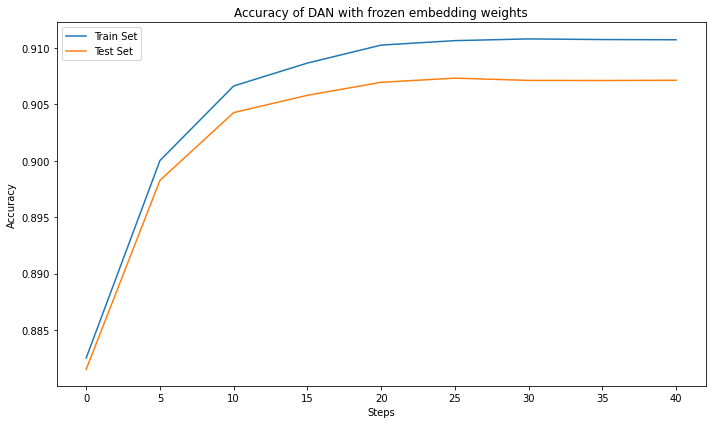

In [18]:
fig, ax = plt.subplots(num=1, clear=True, figsize=(10,6))
DataFrame.from_dict({err: {k: v[err] for k,v in accuracy[max_layers].items()}
                     for err in ['train', 'test']}).plot(ax=ax)
ax.set_title(f'Accuracy of DAN with frozen embedding weights')
ax.set_xlabel('Steps')
ax.set_ylabel('Accuracy')
ax.legend(['Train Set', 'Test Set'], loc='upper left')
plt.tight_layout()
plt.savefig(os.path.join(imgdir, f"frozen_accuracy.jpg"))
plt.show()

## Confusion Matrix

- Both test set and especially training set classification accuracy were poorer compared to statistical learning models, which also used stemmed and lemmatized word inputs encoded as one-hot features.
- When specific words are required to determine classification, average word embeddings (where many words appear similar) may not work as well as distinct word indexes.

In [19]:
from sklearn.metrics import confusion_matrix
labels = [event_[e] for e in event_encoder.classes_]
cf_train = DataFrame(confusion_matrix(train_gold, train_pred),
              index=pd.MultiIndex.from_product([['Actual'], labels]),
              columns=pd.MultiIndex.from_product([['Predicted'], labels]))
cf_train

Predicted  \
                                                  Seeking Acquisitions/Investments   
Actual Seeking Acquisitions/Investments                                      10054   
       Executive/Board Changes - Other                                          11   
       Strategic Alliances                                                       6   
       Client Announcements                                                      4   
       Announcements of Earnings                                                 0   
       Corporate Guidance - New/Confirmed                                        0   
       Business Expansions                                                      10   
       Product-Related Announcements                                             2   
       Debt Financing Related                                                    5   
       Dividend Affirmations                                                     0   
       Dividend Increases                                                        0   
       Dividend Decreases                                                        0   
       Changes in Company Bylaws/Rules                                           0   
       M&A Transaction Announcements                                             5   
       M&A Transaction Closings                                                  4   
       M&A Transaction Cancellations                                             0   
       Private Placements                                                        0   
       Follow-on Equity Offerings                                                0   
       Fixed Income Offerings                                                    1   
       Shelf Registration Filings                                                0   
       Special/Extraordinary Shareholders Meeting                                0   
       Executive Changes - CEO                                                   0   
       Executive Changes - CFO                                                   0   
       Buyback Tranche Update                                                    0   
       Buyback Transaction Announcements                                         0   

                                                                                   \
                                                  Executive/Board Changes - Other   
Actual Seeking Acquisitions/Investments                                        22   
       Executive/Board Changes - Other                                      98393   
       Strategic Alliances                                                     44   
       Client Announcements                                                   299   
       Announcements of Earnings                                                0   
       Corporate Guidance - New/Confirmed                                       3   
       Business Expansions                                                    276   
       Product-Related Announcements                                           86   
       Debt Financing Related                                                  15   
       Dividend Affirmations                                                   21   
       Dividend Increases                                                       9   
       Dividend Decreases                                                       3   
       Changes in Company Bylaws/Rules                                         16   
       M&A Transaction Announcements                                           70   
       M&A Transaction Closings                                               115   
       M&A Transaction Cancellations                                            7   
       Private Placements                                                      14   
       Follow-on Equity Offerings                                               0   
       Fixed Income Offerings                     

In [20]:
cf_test = DataFrame(confusion_matrix(test_gold, test_pred),
                    index=pd.MultiIndex.from_product([['Actual'], labels]),
                    columns=pd.MultiIndex.from_product([['Predicted'], labels]))
cf_test

Predicted  \
                                                  Seeking Acquisitions/Investments   
Actual Seeking Acquisitions/Investments                                       2489   
       Executive/Board Changes - Other                                           4   
       Strategic Alliances                                                       2   
       Client Announcements                                                      3   
       Announcements of Earnings                                                 0   
       Corporate Guidance - New/Confirmed                                        0   
       Business Expansions                                                       7   
       Product-Related Announcements                                             1   
       Debt Financing Related                                                    9   
       Dividend Affirmations                                                     0   
       Dividend Increases                                                        0   
       Dividend Decreases                                                        0   
       Changes in Company Bylaws/Rules                                           0   
       M&A Transaction Announcements                                             3   
       M&A Transaction Closings                                                  4   
       M&A Transaction Cancellations                                             0   
       Private Placements                                                        0   
       Follow-on Equity Offerings                                                0   
       Fixed Income Offerings                                                    0   
       Shelf Registration Filings                                                0   
       Special/Extraordinary Shareholders Meeting                                0   
       Executive Changes - CEO                                                   0   
       Executive Changes - CFO                                                   0   
       Buyback Tranche Update                                                    0   
       Buyback Transaction Announcements                                         0   

                                                                                   \
                                                  Executive/Board Changes - Other   
Actual Seeking Acquisitions/Investments                                         8   
       Executive/Board Changes - Other                                      24513   
       Strategic Alliances                                                     15   
       Client Announcements                                                    98   
       Announcements of Earnings                                                1   
       Corporate Guidance - New/Confirmed                                       1   
       Business Expansions                                                     68   
       Product-Related Announcements                                           23   
       Debt Financing Related                                                   6   
       Dividend Affirmations                                                    6   
       Dividend Increases                                                       3   
       Dividend Decreases                                                       4   
       Changes in Company Bylaws/Rules                                          6   
       M&A Transaction Announcements                                           19   
       M&A Transaction Closings                                                48   
       M&A Transaction Cancellations                                            2   
       Private Placements                                                       5   
       Follow-on Equity Offerings                                               0   
       Fixed Income Offerings                     

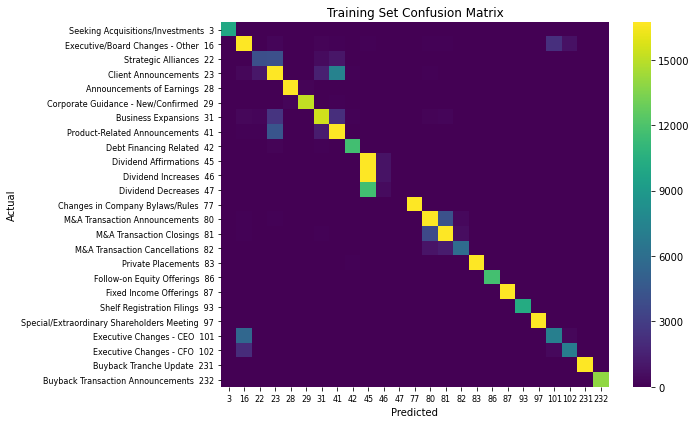

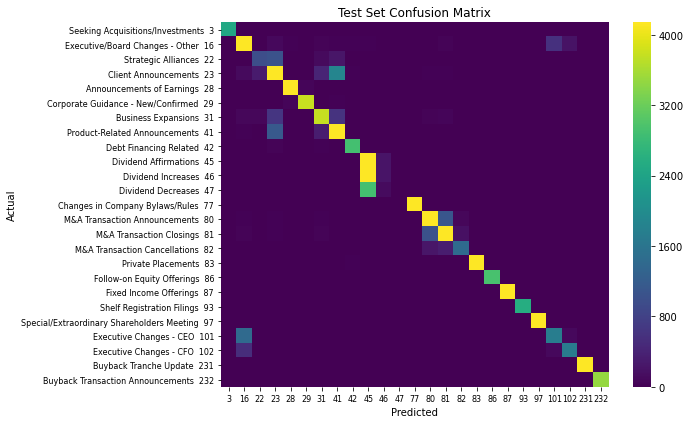

In [21]:
import seaborn as sns
for num, (title, cf) in enumerate({'Training':cf_train,'Test':cf_test}.items()):
    fig, ax = plt.subplots(num=1+num, clear=True, figsize=(10,6))
    sns.heatmap(cf, ax=ax, annot= False, fmt='d', cmap='viridis', robust=True,
                yticklabels=[f"{lab}  {e}"
                             for lab, e in zip(labels, event_encoder.classes_)],
                xticklabels=event_encoder.classes_)
    ax.set_title(f'{title} Set Confusion Matrix')
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')
    ax.yaxis.set_tick_params(labelsize=8, rotation=0)
    ax.xaxis.set_tick_params(labelsize=8, rotation=0)
    plt.subplots_adjust(left=0.35, bottom=0.25)
    plt.savefig(os.path.join(imgdir, f"frozen_{title}.jpg"))
    plt.tight_layout()
plt.show()

## DAN with GloVe embeddings and fine-tune weights
- Construct vocab, and convert str to word indexes
- TextualData class of convenience methods

In [22]:
textdata = TextualData()

if False:
    vocab = textdata.counter(lines)             # count words for vocab
    textdata(vocab.most_common(20000), 0)       # vocab is most common 20000
    textdata.dump('textdata.json', imgdir)

    x_all = textdata[lines]               # convert str docs to word indexes
    with gzip.open(os.path.join(imgdir, 'x_all.json.gz'), 'wt') as f:
        json.dump(x_all, f)
else:
    with gzip.open(os.path.join(imgdir, 'x_all.json.gz'), 'rt') as f:
        x_all = json.load(f)
    textdata.load('textdata.json', imgdir)
print('vocab size', textdata.n)

vocab size 20001


## Relativize GloVe embeddings

- Load GloVe embeddings weights, and drop rows not in vocab

wget http://nlp.stanford.edu/data/wordvecs/glove.6B.zip

unzip glove.6B.zip

Archive:  glove.6B.zip

  inflating: glove.6B.100d.txt       
  inflating: glove.6B.200d.txt       
  inflating: glove.6B.300d.txt       
  inflating: glove.6B.50d.txt    


In [23]:
vocab_dim = 300
glovefile = f"/home/terence/Downloads/sshfs/glove/glove.6B.{vocab_dim}d.txt"
if False:
    glove = textdata.relativize(glovefile)
    pickle_dump(glove, f"glove{vocab_dim}rel.pkl", imgdir)
else:
    glove = pickle_load(f"glove{vocab_dim}rel.pkl", imgdir)
print('glove dimensions', glove.shape)

glove dimensions (20001, 300)


## train_test split stratified by y_all


In [6]:
textdata.form_splits(y_all, random_state=42, test_size=0.2)

(array([ 345369,  808876, 1010749, ..., 1079829,  233513,   76060]),
 array([ 946915,  715945,  180310, ...,  746896,  920693, 1037749]))

## Define DAN with tunable word embeddings

In [9]:
class DAN(nn.Module):
    """Deep Averaging Network for classification"""
    def __init__(self, vocab_dim, num_classes, hidden, embedding,
                 dropout=0.3, requires_grad=False):
        super().__init__()
        self.embedding = nn.EmbeddingBag.from_pretrained(embedding)
        self.embedding.weight.requires_grad = requires_grad
        V = nn.Linear(vocab_dim, hidden[0])
        nn.init.xavier_uniform_(V.weight)
        L = [V, nn.Dropout(dropout)]
        for g, h in zip(hidden, hidden[1:] + [num_classes]):
            W = nn.Linear(g, h)
            nn.init.xavier_uniform_(W.weight)
            L.extend([nn.ReLU(), W])
        self.network = nn.Sequential(*L)
        self.classifier = nn.LogSoftmax(dim=-1)  # output is (N, C) logits

    def tune(self, requires_grad=False):
        self.embedding.weight.requires_grad = requires_grad

    def forward(self, x):
        """Return tensor of log probabilities"""
        return self.classifier(self.network(self.embedding(x)))

    def predict(self, x):
        """Return predicted int class of input tensor vector"""
        return torch.argmax(self(x), dim=1).int().tolist()
                
    def save(self, filename):
        """save model state to filename"""
        return torch.save(self.state_dict(), filename)

    def load(self, filename):
        """load model name from filename"""
        self.load_state_dict(torch.load(filename, map_location='cpu'))
        return self

In [10]:
layers = 2
hidden = vocab_dim   #100, 300
model = DAN(vocab_dim, num_classes, hidden=[hidden]*layers,
            embedding=torch.FloatTensor(glove)).to(device)
print(model)

DAN(
  (embedding): EmbeddingBag(20001, 300, mode=mean)
  (network): Sequential(
    (0): Linear(in_features=300, out_features=300, bias=True)
    (1): Dropout(p=0.3, inplace=False)
    (2): ReLU()
    (3): Linear(in_features=300, out_features=300, bias=True)
    (4): ReLU()
    (5): Linear(in_features=300, out_features=25, bias=True)
  )
  (classifier): LogSoftmax(dim=-1)
)


## Training loop

In [11]:
accuracy = dict()
for tune in [False, True]:
    # define model, optimizer, scheduler, loss_function
    model.tune(tune)
    batch_sz, lr, num_lr, step_sz, eval_skip = 64, 0.01, 4, 5, 5 #3, 3, 3 #
    num_epochs = step_sz * num_lr + 1
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, gamma=0.1,
                                                step_size=step_sz)
    loss_function = nn.NLLLoss()
    accuracy[tune] = dict()

    # Loop over epochs and batches
    for epoch in range(0, num_epochs):
        tic = time.time()
        batches = textdata.form_batches(batch_sz)

        total_loss = 0.0
        model.train()
        for batch in tqdm(batches):   # train by batch
            x = textdata.form_input([x_all[idx] for idx in batch]).to(device)
            y = torch.tensor([y_all[idx] for idx in batch]).to(device)
            model.zero_grad()                    # reset model gradient
            log_probs = model(x)                 # run model
            loss = loss_function(log_probs, y)   # compute loss
            total_loss += float(loss)
            loss.backward()           # loss step
            optimizer.step()          # optimizer step
        scheduler.step()          # scheduler step for learning rate
        model.eval()
        model.save(os.path.join(imgdir, f"danGloVe.pt"))
        print(f"Loss on epoch {epoch} (tune={tune}): {total_loss:.1f}")

        with torch.no_grad():
            if epoch % eval_skip == 0:
                test_pred = [model.predict(textdata.form_input(
                    [x_all[i]]).to(device))[0] for i in textdata.test_idx]
                test_gold = [int(y_all[idx]) for idx in textdata.test_idx]
                test_correct = (np.asarray(test_pred) ==
                                np.asarray(test_gold)).sum() 
                train_pred = [model.predict(textdata.form_input(
                    [x_all[i]]).to(device))[0] for i in textdata.train_idx]
                train_gold = [int(y_all[idx]) for idx in textdata.train_idx]
                train_correct = (np.asarray(train_pred) ==
                                 np.asarray(train_gold)).sum() 
                accuracy[tune][epoch] = {
                    'loss': total_loss,
                    'train': train_correct/len(train_gold),
                    'test': test_correct/len(test_gold)}
                print(tune, epoch, int(time.time()-tic),
                      optimizer.param_groups[0]['lr'],
                      train_correct/len(train_gold),
                      test_correct/len(test_gold))

100%|██████████| 15304/15304 [02:59<00:00, 85.47it/s]


Loss on epoch 0 (tune=False): 6038.6
False 0 924 0.01 0.8832744537471922 0.8829165492483184


100%|██████████| 15304/15304 [02:59<00:00, 85.29it/s]


Loss on epoch 1 (tune=False): 5508.6


100%|██████████| 15304/15304 [02:59<00:00, 85.49it/s]


Loss on epoch 2 (tune=False): 5449.6


100%|██████████| 15304/15304 [02:59<00:00, 85.29it/s]


Loss on epoch 3 (tune=False): 5411.8


100%|██████████| 15304/15304 [02:58<00:00, 85.51it/s]


Loss on epoch 4 (tune=False): 5437.4


100%|██████████| 15304/15304 [02:59<00:00, 85.38it/s]


Loss on epoch 5 (tune=False): 4524.0
False 5 912 0.001 0.905058198897284 0.9036720291115822


100%|██████████| 15304/15304 [02:58<00:00, 85.74it/s]


Loss on epoch 6 (tune=False): 4378.1


100%|██████████| 15304/15304 [02:58<00:00, 85.61it/s]


Loss on epoch 7 (tune=False): 4329.5


100%|██████████| 15304/15304 [02:58<00:00, 85.60it/s]


Loss on epoch 8 (tune=False): 4299.0


100%|██████████| 15304/15304 [02:58<00:00, 85.56it/s]


Loss on epoch 9 (tune=False): 4270.8


100%|██████████| 15304/15304 [02:58<00:00, 85.50it/s]


Loss on epoch 10 (tune=False): 4182.7
False 10 925 0.0001 0.9086604043291812 0.9069474905146395


100%|██████████| 15304/15304 [02:59<00:00, 85.35it/s]


Loss on epoch 11 (tune=False): 4175.4


100%|██████████| 15304/15304 [02:59<00:00, 85.35it/s]


Loss on epoch 12 (tune=False): 4170.6


100%|██████████| 15304/15304 [02:59<00:00, 85.34it/s]


Loss on epoch 13 (tune=False): 4170.9


100%|██████████| 15304/15304 [02:59<00:00, 85.30it/s]


Loss on epoch 14 (tune=False): 4160.5


100%|██████████| 15304/15304 [02:59<00:00, 85.47it/s]


Loss on epoch 15 (tune=False): 4143.0
False 15 912 1e-05 0.9090974065754543 0.907196621618862


100%|██████████| 15304/15304 [02:59<00:00, 85.40it/s]


Loss on epoch 16 (tune=False): 4155.3


100%|██████████| 15304/15304 [02:59<00:00, 85.15it/s]


Loss on epoch 17 (tune=False): 4165.2


100%|██████████| 15304/15304 [02:59<00:00, 85.45it/s]


Loss on epoch 18 (tune=False): 4153.2


100%|██████████| 15304/15304 [02:59<00:00, 85.31it/s]


Loss on epoch 19 (tune=False): 4143.2


100%|██████████| 15304/15304 [02:58<00:00, 85.75it/s]


Loss on epoch 20 (tune=False): 4132.9
False 20 918 1.0000000000000002e-06 0.9091137431080253 0.9072129580847127


100%|██████████| 15304/15304 [05:07<00:00, 49.69it/s]


Loss on epoch 0 (tune=True): 6745.6
True 0 1057 0.01 0.9087574024913212 0.903161514553749


100%|██████████| 15304/15304 [05:08<00:00, 49.60it/s]


Loss on epoch 1 (tune=True): 6303.9


100%|██████████| 15304/15304 [05:08<00:00, 49.57it/s]


Loss on epoch 2 (tune=True): 6490.8


100%|██████████| 15304/15304 [05:08<00:00, 49.54it/s]


Loss on epoch 3 (tune=True): 7004.1


100%|██████████| 15304/15304 [05:09<00:00, 49.51it/s]


Loss on epoch 4 (tune=True): 7521.0


100%|██████████| 15304/15304 [05:08<00:00, 49.63it/s]


Loss on epoch 5 (tune=True): 5912.0
True 5 1042 0.001 0.911679599754952 0.9024386259398574


100%|██████████| 15304/15304 [05:08<00:00, 49.68it/s]


Loss on epoch 6 (tune=True): 4734.2


100%|██████████| 15304/15304 [05:07<00:00, 49.70it/s]


Loss on epoch 7 (tune=True): 4129.8


100%|██████████| 15304/15304 [05:08<00:00, 49.57it/s]


Loss on epoch 8 (tune=True): 3800.3


100%|██████████| 15304/15304 [05:07<00:00, 49.79it/s]


Loss on epoch 9 (tune=True): 3706.4


100%|██████████| 15304/15304 [05:07<00:00, 49.75it/s]


Loss on epoch 10 (tune=True): 3417.0
True 10 1056 0.0001 0.9365489074943844 0.9245173595370245


100%|██████████| 15304/15304 [05:07<00:00, 49.75it/s]


Loss on epoch 11 (tune=True): 3546.4


100%|██████████| 15304/15304 [05:09<00:00, 49.44it/s]


Loss on epoch 12 (tune=True): 3590.6


100%|██████████| 15304/15304 [05:08<00:00, 49.67it/s]


Loss on epoch 13 (tune=True): 3566.7


100%|██████████| 15304/15304 [05:08<00:00, 49.62it/s]


Loss on epoch 14 (tune=True): 3347.1


100%|██████████| 15304/15304 [05:08<00:00, 49.66it/s]


Loss on epoch 15 (tune=True): 3519.5
True 15 1038 1e-05 0.9381458035531959 0.9257507627087495


100%|██████████| 15304/15304 [05:08<00:00, 49.64it/s]


Loss on epoch 16 (tune=True): 3351.2


100%|██████████| 15304/15304 [05:08<00:00, 49.64it/s]


Loss on epoch 17 (tune=True): 3431.9


100%|██████████| 15304/15304 [05:08<00:00, 49.66it/s]


Loss on epoch 18 (tune=True): 3612.6


100%|██████████| 15304/15304 [05:08<00:00, 49.64it/s]


Loss on epoch 19 (tune=True): 3470.9


100%|██████████| 15304/15304 [05:08<00:00, 49.59it/s]


Loss on epoch 20 (tune=True): 3347.0
True 20 1039 1.0000000000000002e-06 0.9381988972840515 0.925779351523988


## Confusion matrix

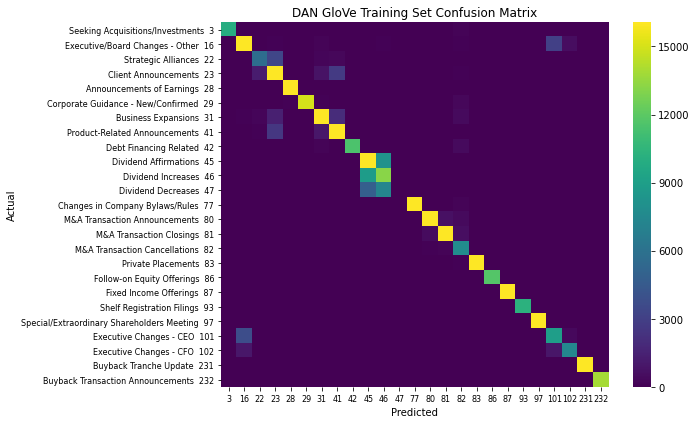

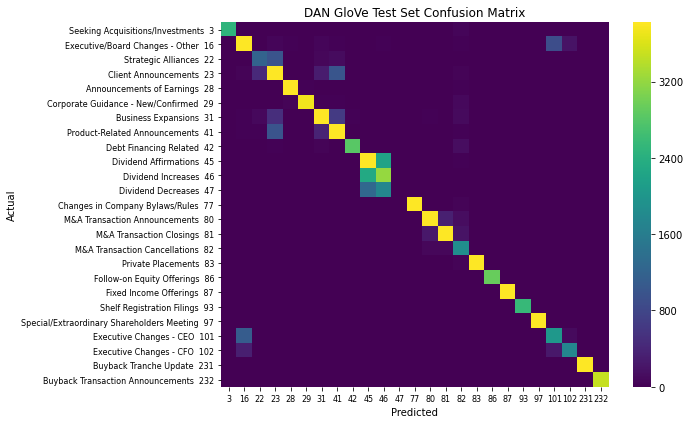

In [12]:
from sklearn.metrics import confusion_matrix
labels = [event_[e] for e in event_encoder.classes_]
cf_train = DataFrame(confusion_matrix(train_gold, train_pred),
              index=pd.MultiIndex.from_product([['Actual'], labels]),
              columns=pd.MultiIndex.from_product([['Predicted'], labels]))
cf_test = DataFrame(confusion_matrix(test_gold, test_pred),
                    index=pd.MultiIndex.from_product([['Actual'], labels]),
                    columns=pd.MultiIndex.from_product([['Predicted'], labels]))

import seaborn as sns
for num, (title, cf) in enumerate({'Training':cf_train,'Test':cf_test}.items()):
    fig, ax = plt.subplots(num=1+num, clear=True, figsize=(10,6))
    sns.heatmap(cf, ax=ax, annot= False, fmt='d', cmap='viridis', robust=True,
                yticklabels=[f"{label}  {e}"
                             for label,e in zip(labels,event_encoder.classes_)],
                xticklabels=event_encoder.classes_)
    ax.set_title(f'DAN Tuned GloVe {title} Set Confusion Matrix')
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')
    ax.yaxis.set_tick_params(labelsize=8, rotation=0)
    ax.xaxis.set_tick_params(labelsize=8, rotation=0)
    plt.subplots_adjust(left=0.35, bottom=0.25)
    plt.savefig(os.path.join(imgdir, f"tuned_{title}.jpg"))
    plt.tight_layout()
plt.show()


## Plot accuracy by epoch

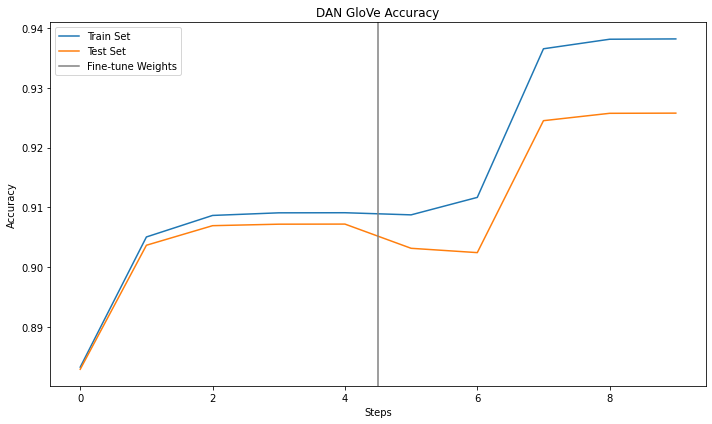

In [16]:
print_skip = 1
fig, ax = plt.subplots(num=1, clear=True, figsize=(10,6))
DataFrame.from_dict({err: {(t*len(accuracy[t]) + k) * print_skip: v[err]
                           for t in [False, True]
                           for k,v in enumerate(accuracy[t].values())}
                     for err in ['train', 'test']}).plot(ax=ax)
ax.axvline((len(accuracy[False]) - 0.5) * print_skip, c='grey', alpha=1)
ax.set_title(f'Accuracy of DAN with fine-tuned GloVe weights')
ax.set_xlabel('Steps')
ax.set_ylabel('Accuracy')
ax.legend(['Train Set', 'Test Set','Fine-tune Weights'], loc='upper left')
plt.tight_layout()
plt.savefig(os.path.join(imgdir, f"tuned_accuracy.jpg"))
plt.show()

# Spacy Explorations
- hashkey = nlp.vocab.strings[v] : general hash table between vocab strings and ids
- vec = nlp.vocab[v].vector : np array with word embedding vector from vocab string
- row = nlp.vocab.vectors.key2row : dict from word's hashkey to int

- emb = nn.Embedding.from_pretrained(torch.FloatTensor(nlp.vocab.vectors.data))
- emb(row) == vec : equivalence of torch embedding and spacy vector

- token = nlp('king man queen woman')[0]
- token.lower : hashkey
- token.lower_: str
- token.lex_id : row of word vector
- token.has_vector : has word vector representation


In [43]:
doc = nlp('king queen man woman a23kj4j')
line = [tok.lex_id for tok in doc
        if not(tok.is_stop or tok.is_punct or tok.is_oov or tok.is_space)]

vec = (nlp.vocab['king'].vector
       - nlp.vocab['man'].vector
       + nlp.vocab['woman'].vector)
print(vec.shape)
sim = nlp.vocab.vectors.most_similar(vec[None,:], n=10)
[nlp.vocab.strings[hashkey] for hashkey in sim[0][0]]

(300,)


['KIng',
 'King',
 'king',
 'KING',
 'Queen',
 'queen',
 'QUEEN',
 'PRINCE',
 'prince',
 'Prince']

In [46]:
# Load pretrained embeddings
emb = nn.Embedding.from_pretrained(torch.FloatTensor(nlp.vocab.vectors.data))

# test for Spacy.nlp and torch.embeddings
test_vocab = ['king', 'man', 'woman', 'queen', 'e9s82j']
for w in test_vocab:
    vocab_id = nlp.vocab.strings[w]
    spacy_vec = nlp.vocab[w].vector
    row = nlp.vocab.vectors.key2row.get(vocab_id, None) # dict 
    if row is None:
        print('{} is oov'.format(w))
        continue
    vocab_row = torch.tensor(row, dtype=torch.long)
    embed_vec = emb(vocab_row)
    print(np.allclose(spacy_vec, embed_vec.detach().numpy()))

for key, row in nlp.vocab.vectors.key2row.items():
    if row == 0: 
        print(nlp.vocab.strings[key])

True
True
True
True
e9s82j is oov
.
